In [57]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import keras
import keras.backend as K
import torch
from torch import nn
import numpy as np
import random
import tensorflow as tf

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras import backend as K

import vggish_params
import torchvggish 

import vggish_postprocess
import scipy as sp


# from : https://discuss.pytorch.org/t/transferring-weights-from-keras-to-pytorch/9889/2
def keras_to_pyt(km, pm):
    weight_dict = dict()
    for layer in km.layers:
        if type(layer) is keras.layers.convolutional.Conv2D:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (3, 2, 0, 1))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
        elif type(layer) is keras.layers.Dense:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (1, 0))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
    pyt_state_dict = pm.state_dict()
    for key in pyt_state_dict.keys():
        pyt_state_dict[key] = torch.from_numpy(weight_dict[key])
    pm.load_state_dict(pyt_state_dict)
    return pm

(1, 1, 96, 64)
(1, 96, 64, 1)

Mean Distance of embeddings (0=identical, -1=orthogonal): -0.2904446850380722
Min distance of embeddings: -0.2904446850380722
68d9c2db


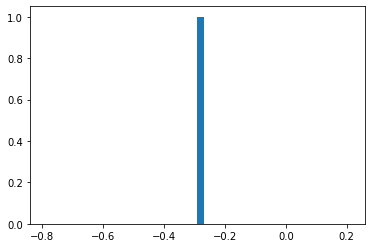

In [59]:
# Define nets

# weight path
# download from here: https://drive.google.com/open?id=1mhqXZ8CANgHyepum7N4yrjiyIg6qaMe6
# (https://github.com/DTaoo/VGGish)
WEIGHTS_PATH = './keras_weights.h5'

def KerasVGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, pooling='avg'):
    '''
    An implementation of the VGGish architecture.
    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'
    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = vggish_params.EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor


    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.0')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.2')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.5')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.6')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.8')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.10')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.11')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.13')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.15')(x)
    # 
    x = Flatten(name='flatten_')(x) 
    x = Dense(4096, activation='relu', name='embeddings.0')(x)
    x = Dense(4096, activation='relu', name='embeddings.2')(x)
    x = Dense(out_dim, activation='relu', name='embeddings.4')(x)


    inputs = aud_input
    # Create model
    model = Model(inputs, x, name='VGGish')
    model.load_weights(WEIGHTS_PATH)

    return model


class VGGish(nn.Module):
    
    def __init__(self):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(  1,  64, kernel_size=3, padding=1), # [batch_size, 64, 64, 96]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 64, 32, 48]  
            nn.Conv2d( 64, 128, kernel_size=3, padding=1), # [batch_size, 128, 32, 48]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 128, 16, 24]
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # [batch_size, 256, 16, 24]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # [batch_size, 256, 16, 24]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 256, 8, 12]
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # [batch_size, 512, 8, 12]
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # [batch_size, 512, 8, 12]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # [batch_size, 512, 4, 6] 
        )
        self.embeddings = nn.Sequential(
            nn.Linear(512*4*6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128),
            nn.ReLU(inplace=True))
                    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.embeddings(x)
        return x
    
def TorchVGGish():
    net = VGGish()
    return net



keras_model = KerasVGGish()
pyt_model = TorchVGGish().eval()
pyt_model = keras_to_pyt(keras_model, pyt_model)

pproc = vggish_postprocess.Postprocessor("vggish_pca_params.npz")

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

distances = []
for i in tqdm_notebook(range(1)):
    inp = np.random.normal(size=(1, 1, 96, 64)).astype(dtype=np.float32)
    print(inp.shape)
    inp_pyt = torch.autograd.Variable(torch.from_numpy(inp.copy()).float())
    inp_keras = np.transpose(inp.copy(), (0, 2, 3, 1))
    print(inp_keras.shape)
    
    keras_result = keras_model.predict(x=inp_keras, verbose=0)
    pyt_res = pyt_model(inp_pyt).data.numpy()
    
    embedding_pt = pproc.postprocess(pyt_res)
    embedding_keras = pproc.postprocess(keras_result)
    
    distance = sp.spatial.distance.cosine(embedding_keras,embedding_pt)
    distances.append(distance)
print("Mean Distance of embeddings (0=identical, -1=orthogonal): {}".format(np.mean(distances)))
print("Min distance of embeddings: {}".format(np.min(distances)))

plt.hist(distances, bins=50)
plt.plot()

model = torchvggish.VGGish()
model.load_state_dict(pyt_model.state_dict(), strict=False)
torch.save(model.state_dict(), "./vggish-weights.pth")
# Get first 8 chars of sha 256 hash for uploading 
! shasum -a 256 ./vggish-weights.pth | awk '{print substr($0,0,8)}'

INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters from vggish_model.ckpt
INFO:tensorflow:Restoring parameters fro

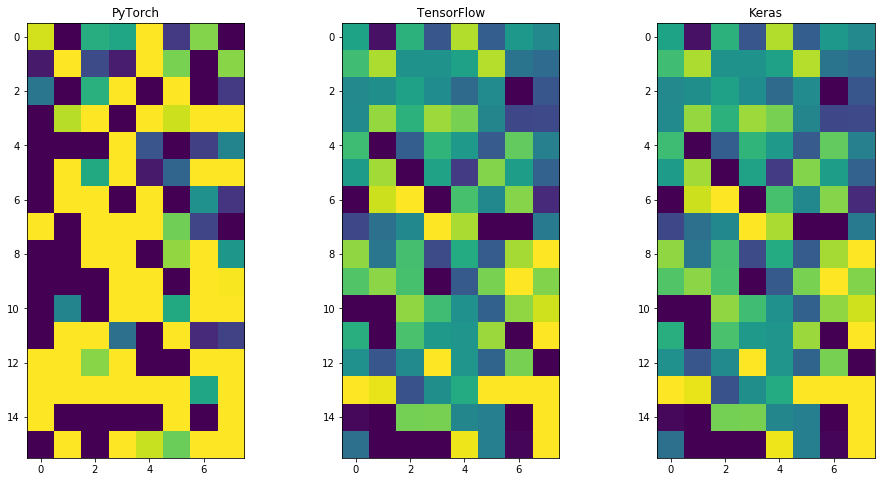

In [63]:
# comparison
import os
import random
import gzip
import vggish_input
import vggish_postprocess
import vggish_params
import vggish_slim
from tqdm import tqdm_notebook
import scipy as sp

pt_distances = []
for i in tqdm_notebook(range(100)):

    def example_generator(base_path):
        """
        Emits random examples from partition of audioset
        """
        eval_files = os.listdir(base_path)
        random.shuffle(eval_files)
        while True:
            eg_file = base_path + eval_files.pop(0)
            with gzip.open(eg_file, 'rb') as wav_file:
                yield vggish_input.wavfile_to_examples(wav_file)[0:1]

    eval_path = "../../data/audioset_eval/"
    data_generator = example_generator(eval_path)
    pproc = vggish_postprocess.Postprocessor("vggish_pca_params.npz")
    examples_batch = next(data_generator)

    # Create an embedding with tensorflow vggish
    with tf.Graph().as_default(), tf.Session() as sess:
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, "vggish_model.ckpt")
        features_tensor = sess.graph.get_tensor_by_name(
            vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(
            vggish_params.OUTPUT_TENSOR_NAME)

        # Run inference and postprocessing.
        [tf_embedding_batch] = sess.run([embedding_tensor],
                                     feed_dict={features_tensor: examples_batch})
        tf_postprocessed_batch = pproc.postprocess(tf_embedding_batch)
    
    # Create an embedding with keras
    inp_keras = examples_batch[:,:,:,None].astype(dtype=np.float32)
    k_embedding_batch = keras_model.predict(inp_keras)
    k_postprocessed_batch = pproc.postprocess(k_embedding_batch)
    
    # Create an embedding with pytorch
    inp_pyt = np.transpose(inp_keras.copy(), (0, 3, 1, 2))
    inp_pyt = torch.autograd.Variable(torch.from_numpy(inp_pyt).float())
    pt_embedding_batch = pyt_model(inp_pyt).data.numpy()
    pt_postprocessed_batch = pproc.postprocess(pt_embedding_batch)
    
    
  
    #Create an embedding with pytorch vggish
#     pt_examples_batch = examples_batch.copy()[:,None,:,:]
    # print(examples_batch.shape)
    # pt_examples_batch = np.transpose(pt_examples_batch, (0, 3, 1, 2))
#     pt_examples_batch = torch.from_numpy(pt_examples_batch).float()
#     pt_embedding_batch = model(pt_examples_batch)
#     pt_embedding_batch = pt_embedding_batch.data.numpy()
    

    # print("PyTorch: {}".format(pt_postprocessed_batch[0]))
    # print("TensorF: {}".format(tf_postprocessed_batch[0]))
    for i in range(len(pt_postprocessed_batch)):
        pt_distances.append(sp.spatial.distance.cosine(pt_postprocessed_batch[i], 
                                                    k_postprocessed_batch[i]))
        
        

    
print(all(True for elem in (k_postprocessed_batch == tf_postprocessed_batch)))
print("Mean Distance of pt embeddings (0=identical, -1=orthogonal): {}".format(np.mean(distances)))
print("Min distance of pt embeddings: {}".format(np.min(distances)))

fig=plt.figure(figsize=(16,8))
fig.add_subplot(1,3,1)
plt.imshow(np.reshape(pt_postprocessed_batch[0],(16,8)))
plt.title("PyTorch")
fig.add_subplot(1,3,2)
plt.imshow(np.reshape(tf_postprocessed_batch[0],(16,8)))
plt.title("TensorFlow")
fig.add_subplot(1,3,3)
plt.imshow(np.reshape(k_postprocessed_batch[0],(16,8)))
plt.title("Keras")
plt.show()

In [64]:
print("Mean Distance of pt embeddings (0=identical, -1=orthogonal): {}".format(np.mean(pt_distances)))
print("Min distance of pt embeddings: {}".format(np.min(pt_distances)))

Mean Distance of pt embeddings (0=identical, -1=orthogonal): -0.3834115944823616
Min distance of pt embeddings: -0.7432834237019283


In [182]:
WEIGHTS_PATH = './keras_weights.h5'
# tf.set_random_seed(42)
# random.seed(41)
# np.random.seed(42)
# torch.manual_seed(42)

def keras_to_pyt(km, pm):
    weight_dict = dict()
    for layer in km.layers:
        if type(layer) is keras.layers.convolutional.Conv2D:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (3, 2, 0, 1))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
        elif type(layer) is keras.layers.Dense:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (1, 0))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
    pyt_state_dict = pm.state_dict()
    for key in pyt_state_dict.keys():
        pyt_state_dict[key] = torch.from_numpy(weight_dict[key])
    pm.load_state_dict(pyt_state_dict)
    return pm

def KerasVGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, pooling='avg'):
    '''
    An implementation of the VGGish architecture.
    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'
    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = vggish_params.EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor


    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.0')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.2')(x)

#     # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.5')(x)

#     # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.6')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.8')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.10')(x)

#     # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.11')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='features.13')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='features.15')(x)
#     # 
    x = Flatten(name='flatten_')(x) 
    x = Dense(4096, activation='relu', name='embeddings.0')(x)
    x = Dense(4096, activation='relu', name='embeddings.2')(x)
    x = Dense(out_dim, activation='relu', name='embeddings.4')(x)


    inputs = aud_input
    # Create model
    model = Model(inputs, x, name='VGGish')
#     model.load_weights(WEIGHTS_PATH)

    return model


class VGGish(nn.Module):
    
    def __init__(self):
        super(VGGish, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(  1,  64, kernel_size=3, padding=1), # [batch_size, 64, 64, 96]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 64, 32, 48]  
            nn.Conv2d( 64, 128, kernel_size=3, padding=1), # [batch_size, 128, 32, 48]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 128, 16, 24]
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # [batch_size, 256, 16, 24]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # [batch_size, 256, 16, 24]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # [batch_size, 256, 8, 12]
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # [batch_size, 512, 8, 12]
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # [batch_size, 512, 8, 12]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # [batch_size, 512, 4, 6] 
        )
        self.embeddings = nn.Sequential(
            nn.Linear(512*4*6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128),
            nn.ReLU(inplace=True)
        )
                    
    def forward(self, x):
        x = self.features(x)
        x = torch.transpose(x, 1, 3).contiguous()
        x = torch.transpose(x, 1, 2).contiguous()
        x = x.view(x.size(0),-1)
        print(x.shape)
        x = self.embeddings(x)
        return x
    
def TorchVGGish():
    net = VGGish()
    return net



keras_model = KerasVGGish()
pyt_model = TorchVGGish().eval()
pyt_model = keras_to_pyt(keras_model, pyt_model)

base_path = "../../data/audioset_eval/"
eval_files = os.listdir(base_path)
eg_file = base_path + eval_files.pop(0)
with gzip.open(eg_file, 'rb') as wav_file:
    inp = vggish_input.wavfile_to_examples(wav_file)[0:1][None,:,:,:].astype(dtype=np.float32)

# print(inp.shape)
# inp = np.random.normal(size=(1, 1, 96, 64)).astype(dtype=np.float32)
inp_pyt = torch.autograd.Variable(torch.from_numpy(inp.copy()).float())
inp_keras = np.transpose(inp.copy(), (0, 2, 3, 1))

keras_result = keras_model.predict(x=inp_keras, verbose=0)
# features 
# pyt_result = np.transpose(pyt_model(inp_pyt).data.numpy(), (0, 2, 3, 1))
pyt_result = pyt_model(inp_pyt).data.numpy()

cumulative_distance = 0
# Feature layers are ok! 
# for i in range(1):
#     for j in range(6):
#         for k in range(4):
#             for l in range(512):
# #                 print(keras_result.shape)
# #                 print(pyt_result.shape)
#                 local_distance = keras_result[i, j, k, l] - pyt_result[i, j, k, l]
#                 cumulative_distance += local_distance
# #                 print(keras_result[i, j, k, l], pyt_result[i, j, k, l])
# #                 print("distance: {}".format(local_distance))
# print(cumulative_distance)

# # flatten layer
# for i in range(12288):
#     cumulative_distance += (keras_result[0][i] - pyt_result[i])
# print(cumulative_distance)

print(keras_result.shape)

# embedding layer 
for i in range(128):
    cumulative_distance += (round(keras_result[0][i],5) - round(pyt_result[0][i],5))
print("Cumulative distance (5.d.p): {}".format( cumulative_distance))



# embedding_pt = pproc.postprocess(pyt_res)
# embedding_keras = pproc.postprocess(keras_result)

# distance = sp.spatial.distance.cosine(keras_result, pyt_result)
# print(distance)

torch.Size([1, 12288])
(1, 128)
Cumulative distance (5.d.p): -1.9999220967292786e-05


In [178]:
# comparison
import os
import random
import gzip
import vggish_input
import vggish_postprocess
import vggish_params
import vggish_slim
from tqdm import tqdm_notebook
import scipy as sp

pt_distances = []
for i in tqdm_notebook(range(100)):

    def example_generator(base_path):
        """
        Emits random examples from partition of audioset
        """
        eval_files = os.listdir(base_path)
        random.shuffle(eval_files)
        while True:
            eg_file = base_path + eval_files.pop(0)
            with gzip.open(eg_file, 'rb') as wav_file:
                yield vggish_input.wavfile_to_examples(wav_file)

    eval_path = "../../data/audioset_eval/"
    data_generator = example_generator(eval_path)
    pproc = vggish_postprocess.Postprocessor("vggish_pca_params.npz")
    examples_batch = next(data_generator)

    # Create an embedding with tensorflow vggish
    with tf.Graph().as_default(), tf.Session() as sess:
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, "vggish_model.ckpt")
        features_tensor = sess.graph.get_tensor_by_name(
            vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(
            vggish_params.OUTPUT_TENSOR_NAME)

        # Run inference and postprocessing.
        [tf_embedding_batch] = sess.run([embedding_tensor],
                                     feed_dict={features_tensor: examples_batch})
        tf_postprocessed_batch = pproc.postprocess(tf_embedding_batch)
    
    # Create an embedding with keras
    inp_keras = examples_batch[:,:,:,None].astype(dtype=np.float32)
    k_embedding_batch = keras_model.predict(inp_keras)
    k_postprocessed_batch = pproc.postprocess(k_embedding_batch)
    
    # Create an embedding with pytorch
    inp_pyt = np.transpose(inp_keras.copy(), (0, 3, 1, 2))
    inp_pyt = torch.autograd.Variable(torch.from_numpy(inp_pyt).float())
    pt_embedding_batch = pyt_model(inp_pyt).data.numpy()
    pt_postprocessed_batch = pproc.postprocess(pt_embedding_batch)
    
    
  
    #Create an embedding with pytorch vggish
#     pt_examples_batch = examples_batch.copy()[:,None,:,:]
    # print(examples_batch.shape)
    # pt_examples_batch = np.transpose(pt_examples_batch, (0, 3, 1, 2))
#     pt_examples_batch = torch.from_numpy(pt_examples_batch).float()
#     pt_embedding_batch = model(pt_examples_batch)
#     pt_embedding_batch = pt_embedding_batch.data.numpy()
    

    # print("PyTorch: {}".format(pt_postprocessed_batch[0]))
    # print("TensorF: {}".format(tf_postprocessed_batch[0]))
    for i in range(len(pt_postprocessed_batch)):
        pt_distances.append(sp.spatial.distance.cosine(pt_postprocessed_batch[i], 
                                                    k_postprocessed_batch[i]))
        
        

    
print(all(True for elem in (k_postprocessed_batch == tf_postprocessed_batch)))
print("Mean Distance of pt embeddings (0=identical, -1=orthogonal): {}".format(np.mean(distances)))
print("Min distance of pt embeddings: {}".format(np.min(distances)))

fig=plt.figure(figsize=(16,8))
fig.add_subplot(1,3,1)
plt.imshow(np.reshape(pt_postprocessed_batch[0],(16,8)))
plt.title("PyTorch")
fig.add_subplot(1,3,2)
plt.imshow(np.reshape(tf_postprocessed_batch[0],(16,8)))
plt.title("TensorFlow")
fig.add_subplot(1,3,3)
plt.imshow(np.reshape(k_postprocessed_batch[0],(16,8)))
plt.title("Keras")
plt.show()

INFO:tensorflow:Restoring parameters from vggish_model.ckpt



RuntimeError: size mismatch, m1: [1 x 122880], m2: [12288 x 4096] at /Users/distiller/project/conda/conda-bld/pytorch_1556653464916/work/aten/src/TH/generic/THTensorMath.cpp:961